In [1]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,TLRY.Low,TLRY.Close,TLRY.Volume,TLRY.Adjusted,MU.Open,MU.High,MU.Low,MU.Close,MU.Volume,MU.Adjusted
863,2019-06-10,182.250000,184.850006,182.210007,183.149994,41385300,183.149994,210.250000,216.940002,209.009995,...,41.029999,43.139999,7322600,43.139999,34.599998,35.540001,34.520000,34.939999,21728000,34.939999
864,2019-06-11,185.059998,185.399994,182.779999,183.399994,41260300,183.399994,219.139999,220.899994,213.500000,...,40.139999,40.490002,2898900,40.490002,35.799999,35.990002,34.750000,34.840000,19208600,34.840000
865,2019-06-12,182.899994,183.279999,182.000000,182.339996,27758100,182.339996,222.949997,223.380005,209.000000,...,39.430000,41.820000,1702500,41.820000,34.009998,34.099998,32.730000,32.959999,28746500,32.959999
866,2019-06-13,183.100006,183.869995,182.740005,183.419998,23715800,183.419998,210.380005,214.899994,207.509995,...,40.400002,40.700001,1167200,40.700001,33.080002,33.639999,33.009998,33.380001,16586700,33.380001
867,2019-06-14,182.479996,183.110001,181.940002,182.639999,22834000,182.639999,211.250000,216.649994,210.399994,...,38.700001,39.009998,1368200,39.009998,32.450001,32.840000,32.240002,32.660000,19700800,32.660000


In [3]:
vol_data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility.csv')
vol_data20_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility20.csv')
#vol_data50_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility50.csv')
#vol_data100_orig = pd.read_csv('../data/files/multiple_concatenated_tickers_volatility100.csv')
vol_data_orig.tail()

,Index,volatilityQQQ,volatilityTSLA,volatilityMSFT,volatilityINTC,volatilityAAPL,volatilityNFLX,volatilityAMZN,volatilityFB,volatilityGOOG,...,volatilityXLY,volatilityXLP,volatilityXLV,volatilityXLF,volatilityXLK,volatilityXTL,volatilityXLU,volatilityXLRE,volatilityTLRY,volatilityMU
863,2019-06-10,0.262443,0.574566,0.333510,0.253769,0.281142,0.381002,0.409732,0.517354,0.406953,...,0.202950,0.150711,0.130785,0.183441,0.267121,0.202553,0.168077,0.155938,1.063379,0.412362
864,2019-06-11,0.253383,0.573597,0.326130,0.252188,0.269323,0.369345,0.404458,0.531756,0.402374,...,0.187672,0.134942,0.109451,0.181765,0.260561,0.200543,0.150839,0.130113,1.092160,0.414424
865,2019-06-12,0.259465,0.628408,0.331261,0.266931,0.278214,0.377129,0.405765,0.535325,0.401467,...,0.189846,0.136326,0.109338,0.192895,0.268465,0.203165,0.158621,0.129671,1.072741,0.527995
866,2019-06-13,0.231038,0.605956,0.304988,0.239902,0.232847,0.353386,0.375983,0.518845,0.404909,...,0.156865,0.076984,0.091795,0.159182,0.234898,0.125690,0.158864,0.127678,1.070979,0.517080
867,2019-06-14,0.172617,0.533444,0.202580,0.234044,0.224527,0.340522,0.205248,0.225017,0.167734,...,0.131051,0.074474,0.099594,0.159437,0.207356,0.149072,0.159537,0.127758,0.946152,0.533473


In [4]:
data_orig = data_orig\
  .merge(vol_data_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_y"], axis=1)\
  .merge(vol_data20_orig, how="inner", left_on=data_orig.Index, right_on=vol_data_orig.Index).fillna(method="ffill")\
  .drop(["key_0", "Index_x"], axis=1)

In [5]:
[i for i in list(data_orig.columns) if i == 'Index']

['Index']

In [6]:
from urllib.request import *
from io import StringIO
import pandas as pd

def df_from_fred(setname):
    # Make GET Request
    response = urlopen(url_for(setname))
    # Read response data
    data = response.read()
    # Convert binary text to utf-8
    text = data.decode('utf-8')
    # Convert text file to pandas dataframe
    TEXTDATA = StringIO(text)
    df = pd.read_csv(TEXTDATA, sep=",")
    return df

def url_for(series):
    """function takes FRED series name as input. For example, GDPC1, or HOUST."""
    return "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=968&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id="+series+"&scale=left&cosd=1947-01-01&coed=2019-01-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=lin&vintage_date=2019-05-07&revision_date=2019-05-07&nd=1947-01-01"


In [7]:
# Vital Economic indicators: https://gist.github.com/ngopal/262fce10a7fa4a8467f0c61a13c85dc5
GDPC1 = df_from_fred("GDPC1")
time.sleep(5)
M2 = df_from_fred("M2")
time.sleep(5)
CPALTT01USQ657N = df_from_fred("CPALTT01USQ657N")
time.sleep(5)
PPIACO = df_from_fred("PPIACO")
time.sleep(5)
UMCSENT = df_from_fred("UMCSENT")
time.sleep(5)
PAYEMS = df_from_fred("PAYEMS")
time.sleep(5)
RRSFS = df_from_fred("RRSFS")
time.sleep(5)
HOUST = df_from_fred("HOUST")
time.sleep(5)
ISRATIO = df_from_fred("ISRATIO")
time.sleep(5)
SP500 = df_from_fred("SP500")
time.sleep(5)

# Thoughts
FEDFUNDS = df_from_fred("FEDFUNDS")
time.sleep(5)
UNRATE = df_from_fred("UNRATE")
time.sleep(5)
T10Y2Y = df_from_fred("T10Y2Y")
time.sleep(5)
CBBTCUSD = df_from_fred("CBBTCUSD")
time.sleep(5)
USSLIND = df_from_fred("USSLIND")
time.sleep(5)

# Others
IPMAN = df_from_fred("IPMAN")
time.sleep(5)
MPU9900063 = df_from_fred("MPU9900063")
time.sleep(5)
PCU33443344 = df_from_fred("PCU33443344")
time.sleep(5)
MEHOINUSA672N = df_from_fred("MEHOINUSA672N")
time.sleep(5)
TCMDO = df_from_fred("TCMDO")
time.sleep(5)
FGTCMDODNS = df_from_fred("FGTCMDODNS")
time.sleep(5)
ADSLFAA027N = df_from_fred("ADSLFAA027N")
time.sleep(5)
NCBCMDPMVCE = df_from_fred("NCBCMDPMVCE")
time.sleep(5)
FGCCSAQ027S = df_from_fred("FGCCSAQ027S")
time.sleep(5)
ASTNITA = df_from_fred("ASTNITA")
time.sleep(5)
PCETRIM12M159SFRBDAL = df_from_fred("PCETRIM12M159SFRBDAL")

# IPMAN, MPU9900063, PCU33443344, MEHOINUSA672N, TCMDO, FGTCMDODNS, ADSLFAA027N, NCBCMDPMVCE, FGCCSAQ027S, ASTNITA

In [8]:
data_orig = data_orig\
  .merge(GDPC1, how="left", left_on=data_orig.Index, right_on=GDPC1.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(M2, how="left", left_on=data_orig.Index, right_on=M2.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CPALTT01USQ657N, how="left", left_on=data_orig.Index, right_on=CPALTT01USQ657N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PPIACO, how="left", left_on=data_orig.Index, right_on=PPIACO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UMCSENT, how="left", left_on=data_orig.Index, right_on=UMCSENT.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PAYEMS, how="left", left_on=data_orig.Index, right_on=PAYEMS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(RRSFS, how="left", left_on=data_orig.Index, right_on=RRSFS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(HOUST, how="left", left_on=data_orig.Index, right_on=HOUST.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ISRATIO, how="left", left_on=data_orig.Index, right_on=ISRATIO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCETRIM12M159SFRBDAL, how="left", left_on=data_orig.Index, right_on=PCETRIM12M159SFRBDAL.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ASTNITA, how="left", left_on=data_orig.Index, right_on=ASTNITA.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGCCSAQ027S, how="left", left_on=data_orig.Index, right_on=FGCCSAQ027S.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(NCBCMDPMVCE, how="left", left_on=data_orig.Index, right_on=NCBCMDPMVCE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(ADSLFAA027N, how="left", left_on=data_orig.Index, right_on=ADSLFAA027N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FGTCMDODNS, how="left", left_on=data_orig.Index, right_on=FGTCMDODNS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(TCMDO, how="left", left_on=data_orig.Index, right_on=TCMDO.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MEHOINUSA672N, how="left", left_on=data_orig.Index, right_on=MEHOINUSA672N.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(PCU33443344, how="left", left_on=data_orig.Index, right_on=PCU33443344.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(MPU9900063, how="left", left_on=data_orig.Index, right_on=MPU9900063.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(IPMAN, how="left", left_on=data_orig.Index, right_on=IPMAN.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(SP500, how="left", left_on=data_orig.Index, right_on=SP500.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(FEDFUNDS, how="left", left_on=data_orig.Index, right_on=FEDFUNDS.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(UNRATE, how="left", left_on=data_orig.Index, right_on=UNRATE.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(T10Y2Y, how="left", left_on=data_orig.Index, right_on=T10Y2Y.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(CBBTCUSD, how="left", left_on=data_orig.Index, right_on=CBBTCUSD.DATE).fillna(method="ffill")\
  .drop("key_0", axis=1)\
  .merge(USSLIND, how="left", left_on=data_orig.Index, right_on=USSLIND.DATE).fillna(method="ffill")\
  .fillna(-1)

In [9]:
data_orig.drop(['DATE_y', 'DATE_x', 'key_0'], axis=1, inplace=True)

In [393]:
import pickle
import os
from keras.preprocessing import *
from nltk.stem import SnowballStemmer
from dateutil.parser import parse
from datetime import datetime

data = []
for i in os.listdir("../briefings/"):
    #print(i)
    f = open("../briefings/"+str(i), "rb")
    d = pickle.loads(f.read())
    data.append(d)

def categories(n, p):
    n = float(n)
    p = float(p)
    if n >= p:
        return np.array([0, 0, 1])
    if n <= -p:
        return np.array([1, 0, 0])
    else:
        return np.array([0, 1, 0])
    
#Headlines
headlines = []
text_bodies = []
all_text = []
dates = []
datetimes = []
targets = []
snow = SnowballStemmer('english')
for i,v in enumerate(data):
    for k in v:
        if k["date"] == -1:
            continue
        else:
            ticker_data = k["tickerinfo"]
            if not ticker_data:
                continue
            if len(ticker_data[1]) == 4:
                w = parse(k["date"])
#                 targets.append([w, categories(ticker_data[1][3].replace("(","").replace(")","").replace("%",""), 1.0)]) # for softmax
                targets.append([w, float(ticker_data[1][3].replace("(","").replace(")","").replace("%",""))]) # for regression
                headlines.append(''.join([snow.stem(w) for w in str(k["headline"])]))
                text_bodies.append(''.join([snow.stem(w) for w in str(k["text"])]))
                all_text.append(''.join([snow.stem(w) for w in str(k["headline"])]+[snow.stem(w) for w in str(k["text"])]))
                dates.append(w.date().isoformat())
                datetimes.append(parse(k["date"].strip()).isoformat())
#                 all_text.append(''.join([snow.stem(w) for w in str(k["text"])]))
            else:
                continue

tokenizer = text.Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None)

/root/anaconda3/lib/python3.6/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname ET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [7]:
vol_target = data_orig[["volatilityQQQ", "Index"]]
vol_target = vol_target.set_index("Index")

In [8]:
targets_df = pd.DataFrame(targets)
targets_df["DATE"] = [i[0].isoformat(sep=' ').split()[0] for i in targets]
targets_df = targets_df.iloc[:,1:].groupby(['DATE'], as_index=True)
# targets_df.columns = ["pct_change_cat"]
# targets_df.columns = ["full_ts", "pct_change", "DATE"]
targets_df = targets_df.mean().join(vol_target).fillna(0)["volatilityQQQ"]

In [98]:
# targets_df.describe()
targets_df_binary = targets_df.apply(lambda x: 1 if x > 0.1227 else 0)

In [55]:
tokenizer.fit_on_texts(headlines)
encoded_docs = tokenizer.texts_to_matrix(headlines, mode='tfidf')
tfidf_df = pd.DataFrame(encoded_docs)
tfidf_df["DATE"] = dates
tfidf_docs = tfidf_df.groupby(['DATE'], as_index=True).mean()
tfidf_docs

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
DATE,,,,,,,,,,,,,,,,,,,,,
2015-12-31,0.0,0.000000,0.000000,0.166688,0.168285,0.000000,0.363081,0.184052,0.379816,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.000000,0.000000,0.359021,0.000000,0.382083,0.586516,0.594628,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.000000,0.164088,0.166688,0.000000,0.177396,0.181541,0.368103,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,0.000000,0.000000,0.500065,0.000000,0.000000,0.726163,0.184052,0.379816,0.193861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.144468,0.164088,0.500065,0.168285,0.000000,0.544622,0.000000,0.189908,0.387722,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-08,0.0,0.144468,0.000000,0.000000,0.168285,0.000000,0.181541,0.000000,0.000000,0.193861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-11,0.0,0.144468,0.328176,0.666753,0.000000,0.000000,0.181541,0.368103,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-12,0.0,0.000000,0.000000,0.500065,0.000000,0.000000,0.544622,0.184052,0.189908,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-13,0.0,0.000000,0.328176,0.500065,0.168285,0.354792,0.363081,0.368103,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
# tokenizer.fit_on_texts(headlines)
# encoded_docs = tokenizer.texts_to_matrix(headlines, mode='tfidf')
tfidf_texts = pd.DataFrame(headlines)
tfidf_texts["DATE"] = dates
tfidf_texts = tfidf_texts.set_index("DATE").rename(columns={0:"texts"}).groupby(['DATE'])["texts"].transform(lambda x: ' '.join(x).lower()).drop_duplicates()
tfidf_texts

DATE
2016-10-10     indices begin week higher as oil rallies  cru...
2016-10-11    indices limp into earnings season  crude retre...
2016-10-12    averages finish little changed following fed m...
2016-10-13    stocks narrow losses, end lower as trade data ...
2016-10-14    indices walk back gains despite upbeat bank ea...
2016-10-17    bond yields and stocks retreat  crude oil exte...
2016-10-18    stocks end higher as earnings season heats up ...
2016-10-19    stocks inch higher with oil and bank shares in...
2016-10-20    indices end little changed as earnings pour in...
2016-10-21    stocks end flat with m&a and earnings in focus...
2016-10-24    m&a deals and earnings boost stocks  crude era...
2016-10-25    averages end lower as mixed earnings weigh  na...
2016-10-26    dow jones industrial average ends higher, shru...
2016-10-27    stocks slip as bond yields jump  natural gas s...
2016-10-28    stocks end lower as political uncertainty rise...
2016-10-03    stocks end lower as d

In [10]:
tokenizer.word_index

{'stocks': 1,
 'in': 2,
 'oil': 3,
 'higher': 4,
 'the': 5,
 'lower': 6,
 'on': 7,
 'to': 8,
 'crude': 9,
 'of': 10,
 'as': 11,
 'following': 12,
 'at': 13,
 'session': 14,
 'financials': 15,
 'gains': 16,
 's': 17,
 'data': 18,
 'market': 19,
 'gas': 20,
 'energy': 21,
 'highs': 22,
 'ahead': 23,
 'p': 24,
 'wti': 25,
 'eia': 26,
 'gold': 27,
 'for': 28,
 'averages': 29,
 'a': 30,
 'trade': 31,
 'week': 32,
 'tech': 33,
 'consumer': 34,
 'earnings': 35,
 'lead': 36,
 'rally': 37,
 'indices': 38,
 'losses': 39,
 'flat': 40,
 'and': 41,
 '500': 42,
 'open': 43,
 'dow': 44,
 'mixed': 45,
 'technology': 46,
 'health': 47,
 'care': 48,
 'outperform': 49,
 'leads': 50,
 'day': 51,
 'after': 52,
 'natural': 53,
 'back': 54,
 'dollar': 55,
 'new': 56,
 'with': 57,
 'lows': 58,
 'up': 59,
 'commodities': 60,
 'high': 61,
 'off': 62,
 'near': 63,
 'modestly': 64,
 'outperforms': 65,
 'slightly': 66,
 'into': 67,
 'futures': 68,
 'barrel': 69,
 'record': 70,
 'close': 71,
 'rallies': 72,
 'weigh

In [11]:
tfidf_docs.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
DATE,,,,,,,,,,,,,,,,,,,,,
2015-12-31,0.0,0.000000,0.000000,0.166649,0.168245,0.000000,0.362980,0.183999,0.37970,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-04,0.0,0.000000,0.000000,0.358936,0.000000,0.381982,0.586353,0.594458,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-05,0.0,0.000000,0.164051,0.166649,0.000000,0.177349,0.181490,0.367998,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-06,0.0,0.000000,0.000000,0.499947,0.000000,0.000000,0.725961,0.183999,0.37970,0.193799,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-07,0.0,0.144441,0.164051,0.499947,0.168245,0.000000,0.544471,0.000000,0.18985,0.387598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(tfidf_docs.shape)
print(targets_df.shift(-1).dropna().as_matrix().reshape(-1,1).shape)

(870, 5000)
(869, 1)


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [100]:
maxlen = 10

X = tfidf_docs.as_matrix()
y = targets_df.shift(-1).dropna().as_matrix().reshape(-1,1) # predict next day
y_binary = targets_df_binary.shift(-1).dropna().as_matrix().reshape(-1,1)
X = X[0:(tfidf_docs.shape[0]-1)]

print(X.shape)
print(y.shape)
print(y_binary.shape)

from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


(869, 5000)
(869, 1)
(869, 1)
Pad sequences (samples x time)
x_train shape: (695, 5000)
x_test shape: (174, 5000)
x_train (695, 5000)
y_train (695, 1)
x_test (174, 5000)
y_test (174, 1)


In [144]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# integer encode the documents
vocab_size = 5000
encoded_docs = [one_hot(d, vocab_size) for d in tfidf_texts]
# print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 100
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs)
# define the model
embedding_model = Sequential()
embedding_model.add(Embedding(vocab_size, 100, input_length=max_length))
embedding_model.add(Flatten())
embedding_model.add(Dense(1, activation='sigmoid'))
# compile the model
embedding_model.compile(optimizer='adam', loss='binary_crossentropy')
# summarize the model
print(embedding_model.summary())
# fit the model


MODELNAME = 'briefing_embedding_logloss'
earlyStopping = EarlyStopping(monitor='val_loss', patience=16*10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15*10, verbose=1, epsilon=1e-4, mode='min')
tbrd = TensorBoard(log_dir="./logs", histogram_freq=0, batch_size=128, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

# embedding_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5')
history = embedding_model.fit(
    padded_docs[0:(tfidf_docs.shape[0]-1)],
    y_binary,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save, tbrd],
    shuffle=True)
# evaluate the model
embedding_model.evaluate(padded_docs[0:(tfidf_docs.shape[0]-1)], y_binary, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
flatten_33 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 10001     
Total params: 510,001
Trainable params: 510,001
Non-trainable params: 0
_________________________________________________________________
None


/root/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 782 samples, validate on 87 samples
Epoch 1/5000
782/782 [==============================] - 1s 1ms/step - loss: 0.6933 - val_loss: 0.6947
Epoch 2/5000
782/782 [==============================] - 0s 104us/step - loss: 0.6799 - val_loss: 0.6963
Epoch 3/5000
782/782 [==============================] - 0s 99us/step - loss: 0.6662 - val_loss: 0.6976
Epoch 4/5000
782/782 [==============================] - 0s 108us/step - loss: 0.6531 - val_loss: 0.6984
Epoch 5/5000
782/782 [==============================] - 0s 97us/step - loss: 0.6398 - val_loss: 0.6989
Epoch 6/5000
782/782 [==============================] - 0s 110us/step - loss: 0.6254 - val_loss: 0.6988
Epoch 7/5000
782/782 [==============================] - 0s 75us/step - loss: 0.6102 - val_loss: 0.6988
Epoch 8/5000
782/782 [==============================] - 0s 95us/step - loss: 0.5942 - val_loss: 0.6988
Epoch 9/5000
782/782 [==============================] - 0s 93us/step - loss: 0.5772 - val_loss: 0.6989
Epoch 10/5000
782/782 [===

782/782 [==============================] - 0s 108us/step - loss: 0.0088 - val_loss: 0.9039
Epoch 80/5000
782/782 [==============================] - 0s 101us/step - loss: 0.0086 - val_loss: 0.9056
Epoch 81/5000
782/782 [==============================] - 0s 133us/step - loss: 0.0083 - val_loss: 0.9073
Epoch 82/5000
782/782 [==============================] - 0s 128us/step - loss: 0.0081 - val_loss: 0.9090
Epoch 83/5000
782/782 [==============================] - 0s 107us/step - loss: 0.0079 - val_loss: 0.9107
Epoch 84/5000
782/782 [==============================] - 0s 92us/step - loss: 0.0077 - val_loss: 0.9123
Epoch 85/5000
782/782 [==============================] - 0s 83us/step - loss: 0.0075 - val_loss: 0.9139
Epoch 86/5000
782/782 [==============================] - 0s 98us/step - loss: 0.0073 - val_loss: 0.9155
Epoch 87/5000
782/782 [==============================] - 0s 127us/step - loss: 0.0072 - val_loss: 0.9171
Epoch 88/5000
782/782 [==============================] - 0s 93us/step - 

782/782 [==============================] - 0s 69us/step - loss: 0.0023 - val_loss: 1.0001
Epoch 157/5000
782/782 [==============================] - 0s 61us/step - loss: 0.0023 - val_loss: 1.0006
Epoch 158/5000
782/782 [==============================] - 0s 99us/step - loss: 0.0023 - val_loss: 1.0011
Epoch 159/5000
782/782 [==============================] - 0s 74us/step - loss: 0.0022 - val_loss: 1.0015
Epoch 160/5000
782/782 [==============================] - 0s 70us/step - loss: 0.0022 - val_loss: 1.0020
Epoch 161/5000
782/782 [==============================] - 0s 64us/step - loss: 0.0022 - val_loss: 1.0025


0.10234255635182794

In [275]:
fs = open('./stock_embeddings.txt', "w")
for k in list(zip(list(tokenizer.word_index.keys()), embedding_model.layers[0].get_weights()[0])):
    to_write = k[0]+" "+str(' '.join([str(h.item()) for h in k[1]])).replace("[","").replace("]","")+"\n"
    fs.write(to_write)
fs.close()

Loaded 3525 word vectors.
[-0.06631338 -0.02385812  0.05029186 -0.04792999 -0.00997471 -0.04955317
 -0.02845051  0.033544   -0.00025632 -0.00120451 -0.0054974   0.00014578
 -0.00341329 -0.04376417 -0.06344558 -0.05280076 -0.05852904 -0.0367589
 -0.01094232  0.03794248 -0.04548609 -0.02563012  0.00371019 -0.0035556
 -0.05624891  0.07981282  0.01050372 -0.05314203  0.04164872 -0.00978956
 -0.07643912  0.00061095  0.05131291  0.00322724 -0.00442238 -0.04771465
  0.03611193 -0.06921218  0.03448754 -0.0238165   0.00040678  0.01410966
  0.00990953 -0.07660811 -0.04199598 -0.05082068  0.05840357  0.03952853
 -0.08959772 -0.04260951  0.0294521   0.02661574  0.05794331  0.05262617
 -0.03800498  0.02919465 -0.02490522  0.04279638  0.00327575 -0.03521184
  0.01534251  0.00425211  0.03231861 -0.04202428  0.0511444   0.05564181
  0.00970353  0.01404383  0.01135183  0.01279347  0.03567532  0.00063308
  0.01974301  0.02196909  0.05050219  0.0354274   0.05508916  0.02503744
 -0.03355166  0.00050373 -0

fedex 947
related 948
cruising 949
provides 950
central 951
hawkish 952
corn 953
canada 954
maintains 955
good 956
tests 957
exxon 958
delays 959
fox 960
corporate 961
overcomes 962
movement 963
underpin 964
sprint 965
foot 966
ytd 967
reaches 968
starbucks 969
plan 970
extension 971
tuesday's 972
sets 973
renewed 974
flight 975
q1 976
wheat 977
forecast 978
iphone 979
ma 980
economy 981
resiliency 982
de 983
weighed 984
huawei 985
six 986
62 987
71 988
68 989
65 990
taps 991
edges 992
receives 993
2900 994
sessions 995
press 996
reclaims 997
15 998
political 999
gdp 1000
insurers 1001
calm 1002
14 1003
sink 1004
insurance 1005
even 1006
airline 1007
relief 1008
base 1009
wanes 1010
delta 1011
beta 1012
32 1013
recovering 1014
rout 1015
component 1016
linger 1017
event 1018
chicago 1019
pmi 1020
strike 1021
onto 1022
grain 1023
crop 1024
yen 1025
fails 1026
mln 1027
beverage 1028
sale 1029
weaken 1030
recovery 1031
libya 1032
resistance 1033
handle 1034
remaining 1035
stuck 1036
tight 

23 1735
wipes 1736
refining 1737
pacing 1738
endure 1739
avis 1740
marches 1741
bristol 1742
myers 1743
est 1744
meetings 1745
member 1746
libyan 1747
makers 1748
wait 1749
throughout 1750
algiers 1751
am 1752
fear 1753
indicator 1754
very 1755
poor 1756
world 1757
much 1758
pg 1759
kicking 1760
continental 1761
particular 1762
asian 1763
visa 1764
paves 1765
lived 1766
automotive 1767
google 1768
creeping 1769
stands 1770
tropical 1771
storm 1772
chew 1773
penney 1774
dividend 1775
brief 1776
l 1777
passes 1778
night's 1779
semi 1780
9th 1781
newell 1782
wrapped 1783
lot 1784
flattish 1785
individual 1786
railroads 1787
prompts 1788
confirmation 1789
hearing 1790
mitigate 1791
michael 1792
overpower 1793
profits 1794
flynn 1795
leader 1796
christmas 1797
senator 1798
darlings 1799
trailing 1800
lacking 1801
rollback 1802
grinds 1803
done 1804
additional 1805
southern 1806
10th 1807
leaders 1808
however 1809
y 1810
signals 1811
updated 1812
bpd 1813
lightly 1814
acknowledge 1815
enters

mcd 2540
fdx 2541
minimum 2542
43 2543
crudes 2544
aal 2545
care's 2546
subsequent 2547
outlast 2548
car 2549
kbh 2550
financial's 2551
being 2552
spinning 2553
wheels 2554
tad 2555
barre 2556
escape 2557
gradually 2558
highlighted 2559
meaningful 2560
recess 2561
prime 2562
kickoff 2563
tgt 2564
chances 2565
lessen 2566
wireless 2567
eleven 2568
nflx 2569
appliance 2570
manufacturers 2571
slowly 2572
german 2573
webmd 2574
kkr 2575
although 2576
freeport 2577
mcmoran 2578
'repeal 2579
only' 2580
legislation 2581
dept 2582
boarder 2583
adjustment 2584
defining 2585
altria 2586
annoucement 2587
crude's 2588
sizable 2589
especially 2590
perrigo 2591
kohl's 2592
chugging 2593
seesaw 2594
delivers 2595
beating 2596
barcelona 2597
false 2598
steve 2599
bannon's 2600
departure 2601
was 2602
announced 2603
matson 2604
challenges 2605
persuade 2606
utx 2607
nypost 2608
speeches 2609
grocers 2610
amazon's 2611
paul 2612
crawl 2613
speed 2614
dog 2615
luster 2616
playing 2617
food 2618
competiti

fcx 3242
withstanding 3243
spark 3244
western 3245
digital 3246
reached 3247
easing 3248
kept 3249
isolation 3250
temper 3251
venezuela 3252
japanese 3253
celgene 3254
brewing 3255
2700 3256
soothing 3257
boasts 3258
explode 3259
restore 3260
cowen 3261
domestic 3262
cig 3263
impact 3264
nation 3265
national 3266
retakes 3267
overbought 3268
plus 3269
indeed 3270
virtue 3271
responds 3272
favorably 3273
voting 3274
conciliatory 3275
apply 3276
expresses 3277
reservations 3278
800k 3279
widen 3280
oi 3281
teva 3282
search 3283
discouraging 3284
stymies 3285
avoids 3286
favors 3287
mester's 3288
arts 3289
title 3290
reviews 3291
declining 3292
unit 3293
fedspeak 3294
intuit 3295
kraft 3296
heinz 3297
goodyear 3298
benefits 3299
pirelli 3300
ceo's 3301
tire 3302
dealers 3303
wavering 3304
dillard's 3305
appeal 3306
testimonies 3307
geopolitics 3308
stepping 3309
kaplan 3310
medicare 3311
anheuser 3312
busch 3313
treaty 3314
suspension 3315
clorox 3316
outstanding 3317
toward 3318
occur 33

In [349]:
LAYERS = 500

# Embedding + CNN
max_features=tokenizer.num_words
filters = 25
kernel_size = 3
hidden_dims = 250

# load the whole embedding into memory
embeddings_index = dict()
f = open('./stock_embeddings.txt', "r")
for line in f.readlines():
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
# model.add(Embedding(max_features,
#                     embedding_dims,
#                     input_length=maxlen))
# weights = embedding_model.layers[0].get_weights()[0]
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
# e = Embedding(vocab_size, 100, weights=[weights], input_length=max_length, trainable=False)
model.add(e)
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
# model.add(Dense(hidden_dims, kernel_regularizer=regularizers.l1_l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))


start = time.time()
adam = keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mse', optimizer=adam)
print('compilation time : ', time.time() - start)

Loaded 3525 word vectors.
compilation time :  0.0619659423828125


In [350]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_57 (Embedding)     (None, 100, 100)          500000    
_________________________________________________________________
dropout_37 (Dropout)         (None, 100, 100)          0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 98, 25)            7525      
_________________________________________________________________
global_max_pooling1d_19 (Glo (None, 25)                0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 26        
_________________________________________________________________
activation_37 (Activation)   (None, 1)                 0         
Total para

In [351]:
x_train_padded, x_test_padded, y_train, y_test = train_test_split(padded_docs[0:(tfidf_docs.shape[0]-1)], y, test_size = 0.2)
print(padded_docs.shape)
print(y.shape)
print(x_train_padded.shape)
print(x_test_padded.shape)
print(y_train.shape)
print(y_test.shape)

(870, 100)
(869, 1)
(695, 100)
(174, 100)
(695, 1)
(174, 1)


In [352]:
MODELNAME = 'briefing_embedding_cnn'
earlyStopping = EarlyStopping(monitor='val_loss', patience=16, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1, epsilon=1e-4, mode='min')
tbrd = TensorBoard(log_dir="./logs", histogram_freq=0, batch_size=128, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

VALIDATIONSIZE = 0.10
EPOCHS = 5000
# model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train_padded,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save, tbrd],
    shuffle=True)

/root/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 625 samples, validate on 70 samples
Epoch 1/5000
625/625 [==============================] - 2s 3ms/step - loss: 1.7886 - val_loss: 0.0867
Epoch 2/5000
625/625 [==============================] - 0s 540us/step - loss: 0.8063 - val_loss: 1.4079
Epoch 3/5000
625/625 [==============================] - 0s 491us/step - loss: 1.3544 - val_loss: 0.4282
Epoch 4/5000
625/625 [==============================] - 0s 508us/step - loss: 0.6287 - val_loss: 0.2761
Epoch 5/5000
625/625 [==============================] - 0s 499us/step - loss: 0.3717 - val_loss: 0.2459
Epoch 6/5000
625/625 [==============================] - 0s 488us/step - loss: 0.4005 - val_loss: 0.2006
Epoch 7/5000
625/625 [==============================] - 0s 648us/step - loss: 0.2462 - val_loss: 0.1061
Epoch 8/5000
625/625 [==============================] - 0s 528us/step - loss: 0.2026 - val_loss: 0.1396
Epoch 9/5000
625/625 [==============================] - 0s 523us/step - loss: 0.1942 - val_loss: 0.0585
Epoch 10/5000
625/625

Epoch 78/5000
625/625 [==============================] - 0s 511us/step - loss: 0.0079 - val_loss: 0.0093
Epoch 79/5000
625/625 [==============================] - 0s 503us/step - loss: 0.0082 - val_loss: 0.0090
Epoch 80/5000
625/625 [==============================] - 0s 570us/step - loss: 0.0081 - val_loss: 0.0090
Epoch 81/5000
625/625 [==============================] - 0s 547us/step - loss: 0.0078 - val_loss: 0.0090
Epoch 82/5000
625/625 [==============================] - 0s 566us/step - loss: 0.0081 - val_loss: 0.0091
Epoch 83/5000
625/625 [==============================] - 0s 468us/step - loss: 0.0080 - val_loss: 0.0091
Epoch 84/5000
625/625 [==============================] - 0s 525us/step - loss: 0.0076 - val_loss: 0.0091
Epoch 85/5000
625/625 [==============================] - 0s 486us/step - loss: 0.0082 - val_loss: 0.0091
Epoch 86/5000
625/625 [==============================] - 0s 533us/step - loss: 0.0078 - val_loss: 0.0092

Epoch 00086: ReduceLROnPlateau reducing learning rate 

In [69]:
# Write callback that looks for loss below threshold and that loss and val_loss are less than 0.01 difference

In [353]:
# model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
# model.evaluate(x_test, y_test)
model.evaluate(x_test_padded, y_test, batch_size=1)

174/174 [==============================] - 1s 4ms/step


0.008147087667909033

In [354]:
for i in range(100):
    print(headlines[i], model.predict(pad_sequences([one_hot(headlines[i], vocab_size)], maxlen=max_length, padding='post')))

 indices begin week higher as oil rallies  [[0.05918601]]
crude erases all of friday's losses & ends near 1-year highs, natural gas futures extend gains [[0.05506862]]
energy leads in final hour [[0.03823784]]
energy remains in the lead [[0.02836752]]
transports lead industrials  [[0.0270485]]
stocks higher on energy's lead [[0.02932443]]
oil rally boosts broader market at midday [[0.03425518]]
oil pulls back [[0.04718422]]
chipmakers pull back  [[0.03409372]]
banking names outperform  [[0.06156874]]
biotechnology outperforms  [[0.03260193]]
crude oil erases all of friday's losses as comments from saudi arabia & russia circulate [[0.07308648]]
s&p 500 near high  [[0.04104306]]
energy and materials pace advance  [[0.04768578]]
indices limp into earnings season  [[0.03496327]]
crude retreats from yesterday's 1-year highs following this morning's monthly iea data [[0.04569344]]
indices off lows  [[0.0546225]]
oil lower ahead of pit close [[0.06681067]]
averages continue to slide [[0.03642

In [355]:
def predict_based_on_text(text):
    return model.predict(pad_sequences([one_hot(text, vocab_size)], maxlen=max_length, padding='post'))

print(" ")
print(predict_based_on_text("U.S. dollar index weakens"))
print(predict_based_on_text("trade talks begin"))
print(predict_based_on_text("crude oil miss"))
print(predict_based_on_text("microsoft cloud goes down"))

# 6/14
print(" ")
print(predict_based_on_text("Large Cap Underperformance Weighs On Dow"))
print(predict_based_on_text("Wall Street slips on semiconductor weakness"))
print(predict_based_on_text("FAANG stocks trade mixed"))
print(predict_based_on_text("Amazon underpinning resiliency in stock market this week"))
print(predict_based_on_text("Facebook gains on crypto plans"))

#6/21
print(" ")
print(predict_based_on_text("Oil extends yesterday's strong gains as Iran remains a concern"), "21-Jun-19 10:30 ET ", "NEXT UP", 5.70)
print(predict_based_on_text("Energy stocks continue to outperform"), "21-Jun-19 11:00 ET", "NEXT DOWN", 6.15)
print(predict_based_on_text("Looking forward toward U.S.-China trade talks"), "21-Jun-19 11:25 ET ", "NEXT UP", 6.13)
print(predict_based_on_text("Shares of CarMax rise after earnings report"), "21-Jun-19 11:55 ET ", "NEXT DOWN", 5.80)
print(predict_based_on_text("Amazon shows relative weakness"), "21-Jun-19 12:25 ET ", "NEXT UP", 5.65)
print(predict_based_on_text("Stocks market trades mixed after strong week"), "21-Jun-19 12:55 ET ", "NEXT DOWN", 5.75)
print(predict_based_on_text("Dow Tops October 2018 Closing High"), "21-Jun-19 13:30 ET ", "NEXT UP", 5.69)
print(predict_based_on_text("Gold Tops $1400 For The First Time Since 2013"), "21-Jun-19 13:55 ET ", "NEXT DOWN", "?")
print(predict_based_on_text("S&P 500 Jostles With Flat Lines"), "21-Jun-19 14:30 ET  ", "NEXT SAME", "?")

 
[[0.08230875]]
[[0.02900787]]
[[0.03663665]]
[[0.0295359]]
 
[[0.05717293]]
[[0.05173816]]
[[0.02847858]]
[[0.04057971]]
[[0.03727219]]
 
[[0.04740588]] 21-Jun-19 10:30 ET  NEXT UP 5.7
[[0.06308118]] 21-Jun-19 11:00 ET NEXT DOWN 6.15
[[0.06091362]] 21-Jun-19 11:25 ET  NEXT UP 6.13
[[0.03983857]] 21-Jun-19 11:55 ET  NEXT DOWN 5.8
[[0.03733864]] 21-Jun-19 12:25 ET  NEXT UP 5.65
[[0.04510126]] 21-Jun-19 12:55 ET  NEXT DOWN 5.75
[[0.05208862]] 21-Jun-19 13:30 ET  NEXT UP 5.69
[[0.05309333]] 21-Jun-19 13:55 ET  NEXT DOWN ?
[[0.08583087]] 21-Jun-19 14:30 ET   NEXT SAME ?


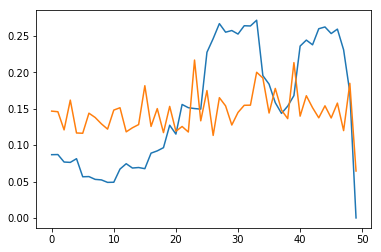

In [360]:
nt = 5*10
tt = [(i[0][1], predict_based_on_text(i[1][1])[0][0]) for i in list(zip(list(targets_df.tail(nt).items()), list(tfidf_texts[list(targets_df.tail(nt).index)].items())))]
plt.plot([i[0] for i in tt])
plt.plot([i[1] for i in tt])


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


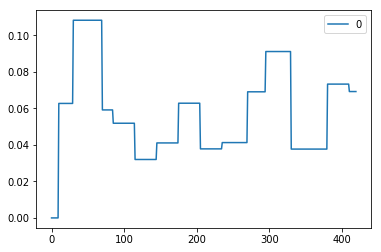

In [535]:
import re
def by_date(bydate):
#     bydate = "2019-06-13"
    date_ranges = [i.isoformat() for i in pd.date_range(parse(bydate+'T09:30:00'), periods=60*7, freq=pd.DateOffset(minutes=1)).tolist()]
    bydates = [i for i in list(zip(datetimes, headlines)) if bydate in i[0]][::-1]

    date_ranges = pd.DataFrame(date_ranges).set_index(0)
    bydates = pd.DataFrame(bydates).set_index(0)
    proportional_df = date_ranges.join(bydates).fillna(' ')
    pd.DataFrame([predict_based_on_text(i[0])[0][0] if i != ' ' else None for i in proportional_df.as_matrix()]).fillna(method="ffill").fillna(0).plot()
    
by_date("2019-05-30")


